In [55]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import optuna

from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)

import joblib

In [2]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# set seed for reproducibility
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# Data preparation

In [15]:
# Load pd_train
pd_train = pd.read_csv("data_smiles/Training_Group.csv")
pd_train["label"] = pd_train["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)
pd_train.head()

(1241, 3)


,Smiles,Liver,label
0,S=C=Nc1c2c(ccc1)cccc2,Hepatotoxicity,1
1,c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...,Hepatotoxicity,1
2,c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O,Hepatotoxicity,1
3,O(CCO)CC,Hepatotoxicity,1
4,Oc1cc2c(cc1)cccc2,Hepatotoxicity,1


In [6]:
# Load pd_test
pd_test = pd.read_csv("data_smiles/Testing_Group.csv")
pd_test["label"] = pd_test["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)
pd_test.head()

(286, 3)


,Smiles,Liver,label
0,C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN...,Hepatotoxicity,1
1,C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl,Hepatotoxicity,1
2,CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(...,Hepatotoxicity,1
3,C1CC2=CC=CC=C2C(C3=CC=CC=C31)NCCCCCCC(=O)O,Hepatotoxicity,1
4,C1=CC=C(C=C1)CN2C3=CC=CC=C3C(=N2)OCC(=O)O,Hepatotoxicity,1


In [16]:
# calculate the length of the Smiles strings
pd_train["smiles_len"] = pd_train["Smiles"].apply(lambda x: len(x))

# filter out the Smiles strings that are too long using the 95% quantile
pd_train = pd_train[pd_train["smiles_len"] <= pd_train["smiles_len"].quantile(0.95)]
print(pd_train.shape)
pd_train.groupby("Liver")["smiles_len"].describe()

(1179, 4)


,count,mean,std,min,25%,50%,75%,max
Liver,,,,,,,,
Hepatotoxicity,651.0,53.345622,27.552502,8.0,36.0,48.0,65.0,168.0
NonHepatotoxicity,528.0,52.698864,27.910168,8.0,35.0,45.0,65.0,169.0


In [27]:
# Tokenize SMILES
df = pd.concat([pd_train, pd_test], axis=0)
unique_chars = set("".join(df["Smiles"]))
char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
vocab_size = len(char_to_idx)


def tokenize_smiles(smiles):
    return [char_to_idx[char] for char in smiles]


# tokenize for X_train, y_train, X_test, y_test
X_train = [tokenize_smiles(s) for s in pd_train["Smiles"]]
y_train = pd_train["label"].values

X_test = [tokenize_smiles(s) for s in pd_test["Smiles"]]
y_test = pd_test["label"].values

print(f"X_train: {len(X_train)}")
print(f"y_train: {len(y_train)}")

print(f"X_test: {len(X_test)}")
print(f"y_test: {len(y_test)}")

X_train: 1179
y_train: 1179
X_test: 286
y_test: 286


In [ ]:
class SmilesDataset(Dataset):
    def __init__(self, smiles, labels, max_len=200):
        self.smiles = [s[:max_len] for s in smiles]
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        x = np.zeros(self.max_len, dtype=int)
        x[: len(self.smiles[idx])] = self.smiles[idx]
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.float)


# Create train and test sets
train_dataset = SmilesDataset(X_train, y_train)
test_dataset = SmilesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [20]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 200]) torch.Size([64])


# Model training

In [37]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        predictions = model(x_batch.to(device)).squeeze(1)
        loss = criterion(predictions, y_batch.to(device))
        loss.backward()
        optimizer.step()


def find_optimal_threshold(y_true, y_pred):
    thresholds = np.linspace(0, 1, 1000)
    best_threshold = 0
    best_score = 0
    for threshold in thresholds:
        predicted_labels = (y_pred > threshold).astype(int)
        score = f1_score(y_true, predicted_labels)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    return best_threshold


def evaluate(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    # Collect predictions and true labels
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            predictions = torch.sigmoid(model(x_batch.to(device)).squeeze(1))
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # threshold = find_optimal_threshold(all_labels, all_predictions)
    threshold = 0.5
    predicted_labels = (all_predictions > threshold).astype(int)

    # Calculate metrics
    auc = roc_auc_score(all_labels, all_predictions)
    precision = precision_score(all_labels, predicted_labels)
    recall = recall_score(all_labels, predicted_labels)  # Recall = Sensitivity
    tn, fp, fn, tp = confusion_matrix(all_labels, predicted_labels).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    results = {
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
    }
    return results

## RNN

In [30]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        out = self.fc(hidden[-1])
        return out

In [41]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        out = self.fc(hidden[-1])  # Use the last hidden state
        return out


In [44]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        out = self.fc(hidden[-1])  # Use the last hidden state
        return out


In [45]:
class BiRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Double the hidden_dim for bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        out = self.fc(torch.cat((hidden[-2], hidden[-1]), dim=1))  # Concatenate last forward and backward hidden states
        return out


In [46]:
class StackedLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(StackedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        out = self.fc(hidden[-1])  # Use the last hidden state of the top layer
        return out


In [47]:
class AttentionRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(AttentionRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)  # Attention weights
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        attention_weights = torch.softmax(self.attention(output), dim=1)
        context_vector = torch.sum(attention_weights * output, dim=1)
        out = self.fc(context_vector)
        return out


In [48]:
class HierarchicalRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, sentence_dim, output_dim):
        super(HierarchicalRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.sentence_rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.document_rnn = nn.RNN(hidden_dim, sentence_dim, batch_first=True)
        self.fc = nn.Linear(sentence_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        sentence_output, _ = self.sentence_rnn(embedded)
        doc_output, _ = self.document_rnn(sentence_output)
        out = self.fc(doc_output[:, -1, :])  # Use the last hidden state of the document-level RNN
        return out


In [49]:
class TransformerRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, nhead=2, num_layers=1):
        super(TransformerRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead),
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        transformed = self.transformer(output)
        out = self.fc(transformed[:, -1, :])  # Use the last hidden state
        return out


In [50]:
class CNNRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, kernel_size=3):
        super(CNNRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(embedding_dim, embedding_dim, kernel_size, padding=1)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x).permute(0, 2, 1)  # Switch to (batch, channels, seq_len) for Conv1d
        conv_output = torch.relu(self.conv1d(embedded)).permute(0, 2, 1)  # Back to (batch, seq_len, channels)
        output, hidden = self.rnn(conv_output)
        out = self.fc(hidden[-1])
        return out


In [ ]:
# Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    embedding_dim = trial.suggest_int("embedding_dim", 8, 64)
    hidden_dim = trial.suggest_int("hidden_dim", 16, 128)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)

    # Model instantiation with suggested hyperparameters
    rnn_model = GRUModel(vocab_size, embedding_dim, hidden_dim, output_dim=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(rnn_model.parameters(), lr=lr)

    train_aucs = []
    test_aucs = []

    # Training loop
    for epoch in range(100):  # Limit epochs for faster Optuna optimization
        train(rnn_model, train_loader, criterion, optimizer)

        # Evaluate on train and test sets
        train_results = evaluate(rnn_model, train_loader)
        test_results = evaluate(rnn_model, test_loader)

        # Store AUCs for plotting later
        train_aucs.append(train_results["AUC"])
        test_aucs.append(test_results["AUC"])

    # Save metrics and model attributes to the trial
    trial.set_user_attr("Best Model", rnn_model.state_dict())
    trial.set_user_attr("Train AUCs", train_aucs)
    trial.set_user_attr("Test AUCs", test_aucs)
    trial.set_user_attr("Final Train AUC", train_aucs[-1])
    trial.set_user_attr("Final Test AUC", test_aucs[-1])

    # Use Test AUC as the objective for Optuna optimization
    trial.report(test_aucs[-1], step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return test_aucs[-1]


# After the study is complete, retrieve the best trial and plot
def plot_aucs(study):
    best_trial = study.best_trial
    train_aucs = best_trial.user_attrs["Train AUCs"]
    test_aucs = best_trial.user_attrs["Test AUCs"]

    # Plot the AUCs
    import matplotlib.pyplot as plt

    plt.plot(train_aucs, label="Train AUC")
    plt.plot(test_aucs, label="Test AUC")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.title("Train and Test AUC Over Epochs")
    plt.legend()
    plt.show()

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [35]:
# Print best trial and all stored metrics
print("Best trial:")
trial = study.best_trial
print(f"AUC Score: {trial.value}")
print("Best Parameters:")
for key, value in trial.params.items():
    print(f"  {key}: {value}")
print("Stored Metrics:")
for metric, value in trial.user_attrs.items():
    print(f"  {metric}: {value}")

Best trial:
AUC Score: 0.5835015663069962
Best Parameters:
  embedding_dim: 37
  hidden_dim: 84
  lr: 0.0009874483053994246
Stored Metrics:
  Train AUCs: [0.5, 0.5, 0.5, 0.5, 0.5134975911185589]
  Test AUCs: [0.5118691263487642, 0.5118691263487642, 0.5118691263487642, 0.5118691263487642, 0.5835015663069962]
  Final Train AUC: 0.5134975911185589
  Final Test AUC: 0.5835015663069962


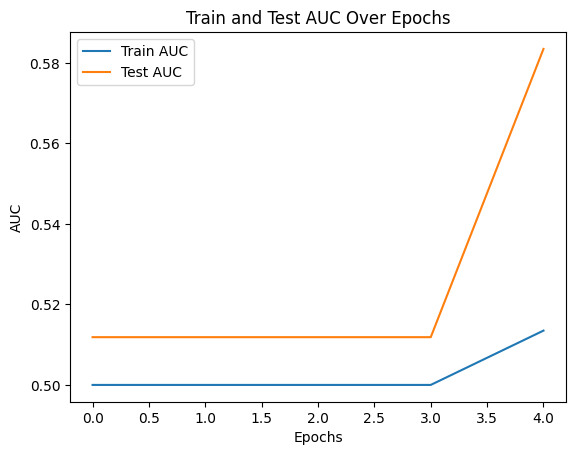

In [34]:
plot_aucs(study)

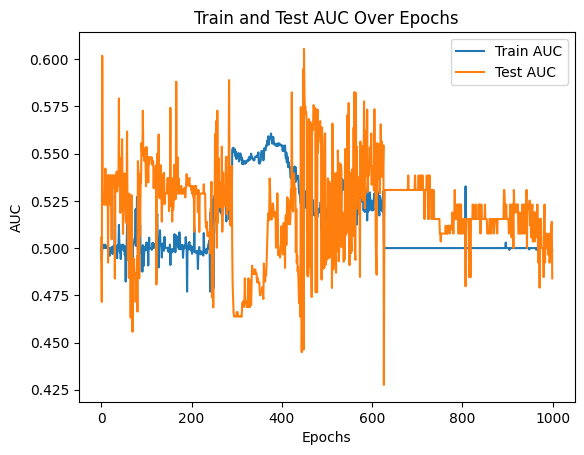

In [39]:
# Model instantiation with suggested hyperparameters
rnn_model = RNNModel(
    vocab_size,
    embedding_dim=trial.params["embedding_dim"],
    hidden_dim=trial.params["hidden_dim"],
    output_dim=1,
).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=trial.params["lr"])

train_aucs = []
test_aucs = []

# Training loop
for epoch in range(1000):  # Limit epochs for faster Optuna optimization
    train(rnn_model, train_loader, criterion, optimizer)

    # Evaluate on train and test sets
    train_results = evaluate(rnn_model, train_loader)
    test_results = evaluate(rnn_model, test_loader)

    # Store AUCs for plotting later
    train_aucs.append(train_results["AUC"])
    test_aucs.append(test_results["AUC"])

# Plot the AUCs
import matplotlib.pyplot as plt

plt.plot(train_aucs, label="Train AUC")
plt.plot(test_aucs, label="Test AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("Train and Test AUC Over Epochs")
plt.legend()
plt.show()

In [53]:
# print max test AUC and the epoch it was achieved
max_test_auc = max(test_aucs)
max_test_auc_epoch = test_aucs.index(max_test_auc)
print(f"Max Test AUC: {max_test_auc} at Epoch {max_test_auc_epoch}")

Max Test AUC: 0.6054298642533937 at Epoch 449


## Loop through all models

In [51]:
# Define all models
model_classes = [
    RNNModel,
    GRUModel,
    LSTMModel,
    BiRNNModel,
    StackedLSTMModel,
    AttentionRNNModel,
    HierarchicalRNNModel,
    TransformerRNNModel,
    CNNRNNModel,
]

In [65]:
def objective(trial):
    # Suggest hyperparameters
    embedding_dim = trial.suggest_int("embedding_dim", 8, 64)
    hidden_dim = trial.suggest_int("hidden_dim", 16, 128)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)

    # Choose the model dynamically
    model_class = trial.suggest_categorical("model_class", model_classes)
    rnn_model = model_class(vocab_size, embedding_dim, hidden_dim, output_dim=1).to(device)

    # Define criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(rnn_model.parameters(), lr=lr)

    train_aucs = []
    test_aucs = []

    # Training loop
    for epoch in range(200):  # Limit epochs for faster Optuna optimization
        train(rnn_model, train_loader, criterion, optimizer)

        # Evaluate on train and test sets
        train_results = evaluate(rnn_model, train_loader)
        test_results = evaluate(rnn_model, test_loader)

        # Store AUCs for plotting later
        train_aucs.append(train_results["AUC"])
        test_aucs.append(test_results["AUC"])

    # print max test AUC and the epoch it was achieved
    max_test_auc = max(test_aucs)
    max_test_auc_epoch = test_aucs.index(max_test_auc)

    # Save metrics and model attributes to the trial
    trial.set_user_attr("Model Class", model_class.__name__)
    trial.set_user_attr("Train AUCs", train_aucs)
    trial.set_user_attr("Test AUCs", test_aucs)
    trial.set_user_attr("Final Train AUC", train_aucs[-1])
    trial.set_user_attr("Final Test AUC", test_aucs[-1])
    trial.set_user_attr("Best Model", rnn_model.state_dict())
    trial.set_user_attr("Max Test AUC", max_test_auc)
    trial.set_user_attr("Max Test AUC Epoch", max_test_auc_epoch)

    # Use Test AUC as the objective for Optuna optimization
    trial.report(test_aucs[-1], step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return max_test_auc

In [66]:
# Save the best model and parameters after optimization
def save_best_model_and_params(study):
    best_trial = study.best_trial
    best_model_class = best_trial.user_attrs["Model Class"]
    best_model_params = best_trial.params
    best_model_state_dict = best_trial.user_attrs["Best Model"]

    print(f"Best Model Class: {best_model_class}")
    print(f"Best Model Parameters: {best_model_params}")
    print(f"Best Test AUC: {best_trial.user_attrs['Max Test AUC']}")
    print(f"Best Test AUC Epoch: {best_trial.user_attrs['Max Test AUC Epoch']}")

    # Save the model and parameters using joblib
    output_data = {
        "best_model": best_model_state_dict,
        "best_model_params": best_model_params,
        "best_model_class": best_model_class,
    }
    joblib.dump(output_data, f"models/nlp_{best_model_class}_best_model.joblib")

    print(f"Best model and parameters saved as '{best_model_class}_best_model.pth' and '{best_model_class}_best_params.json'")


In [ ]:
# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

In [ ]:
# Save the best model and parameters
save_best_model_and_params(study)